In [87]:
import datetime
from sklearn.metrics import r2_score
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
import seaborn as sns
from time import perf_counter
import xgboost as xgb
from joblib import Parallel, delayed
from numpy import linalg as LA
import pandas as pd
from scipy.signal import butter, lfilter, freqz
import preprocess as pre
from tst import Transformer
# from tst import Transformer_with_sst

import os
import pandas as pd
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.neural_network import MLPRegressor

In [2]:
# size of plot titles
plt.rcParams.update({'font.size': 13})

In [40]:
mjo_path = '/share/data/willett-group/mjo_amplitude_updated.h5'

mjo_inds = pd.DataFrame(pd.read_hdf(mjo_path)).reset_index()
mjo_inds.columns = ['date', 'mjo']
mjo_inds#.head()

,date,mjo
0,1979-01-01,1.060090
1,1979-01-02,1.388700
2,1979-01-03,1.547580
3,1979-01-04,1.471080
4,1979-01-05,1.181000
...,...,...
14951,2019-12-08,0.789520
14952,2019-12-09,0.852637
14953,2019-12-10,0.773974
14954,2019-12-11,0.959818


In [41]:
# choose specific dates
mjo = mjo_inds[(mjo_inds['date'] >= '1985-1-1') & (mjo_inds['date'] <= '2019-1-1')]
# mjo = mjo_inds[((mjo_inds['date'] >= '1985-1-1') & (mjo_inds['date'] <= '1992-12-30')) &
#                ((mjo_inds['date'] >= '1993-1-1') &  (mjo_inds['date'] <= '2019-1-1'))]

In [42]:
len(mjo)

12419

In [43]:
# delete one day from 1992 to math tmp shapes (there is smth weird with 1992 in the main dataset)
# i = mjo[(mjo.date == '1992-2-28')].index
# mjo = mjo.drop(i)
mjo_samp = mjo['mjo'].to_numpy().reshape(-1, 1)
mjo_samp = mjo_samp[1:]

In [44]:
target = 'precip'

In [52]:
path = '/share/data/willett-group/'

us_mask = pd.DataFrame(pd.read_hdf(path + 'us_mask.h5'))
# This block is to put all nearby sst data together in time order
# And also transform data into time order (single location\)
# previous lat/lon = 25.25, 279.25
tar_lat = 33.75
tar_lon = 242.25
radius = 5  # For selecting range of locations from target
y_samp = pd.Series()
sst_total = []
precip_total = []
hgt_total = []
rhum_total = []
tmp2m_total = []

# !!! 1985-2019

for i in range(1985,2019):
    print('precip.'+str(i)+'.h5')
    name_precip = 'precip.'+str(i)+'.h5'
    name_sst = 'sst.'+str(i)+'.h5' 
    name_hgt = 'hgt500.'+str(i)+'.h5'
    name_rhum = 'rhum.sig995.'+str(i)+'.h5'
    name_tmp2m = 'tmp2m.'+str(i)+'.h5'
    fileloc_precip = path + name_precip
    fileloc_sst = path + name_sst
    fileloc_hgt = path + name_hgt
    fileloc_rhum = path + name_rhum
    fileloc_tmp2m = path + name_tmp2m
    precip = pd.DataFrame(pd.read_hdf(fileloc_precip)).reset_index() # precipitation
    precip.columns = ['lat', 'lon', 'start_date', 'precip']
#     sst = pd.DataFrame(pd.read_hdf(fileloc_sst)).reset_index() # Daily sea surface temperature
#     sst.columns = ['lat', 'lon', 'start_date', 'sst']
#     hgt = pd.DataFrame(pd.read_hdf(fileloc_hgt)).reset_index() # Daily geopotential height at 10mb and 500mb
#     hgt.columns = ['lat', 'lon', 'start_date', 'hgt']
#     rhum = pd.DataFrame(pd.read_hdf(fileloc_rhum)).reset_index() # Daily relative humidity near the surface
#     rhum.columns = ['lat', 'lon', 'start_date', 'rhum']
#     tmp2m = pd.DataFrame(pd.read_hdf(fileloc_tmp2m)).reset_index() # Daily average temperature at 2 meters
#     tmp2m.columns = ['lat', 'lon', 'start_date', 'tmp2m']
#     print('original', tmp2m.shape)
    
    precip = pd.merge(precip, us_mask, on=['lat','lon'])
#     hgt = pd.merge(hgt, us_mask, on=['lat','lon'])
#     rhum = pd.merge(rhum, us_mask, on=['lat','lon'])
#     tmp2m = pd.merge(tmp2m, us_mask, on=['lat','lon'])
#     print('after merge', tmp2m.shape)
    
#     hgt = np.reshape(hgt[(hgt['lat']==tar_lat) & (hgt['lon']==tar_lon)].hgt.to_numpy(),(-1,1))
#     rhum = np.reshape(rhum[(rhum['lat']==tar_lat) & (rhum['lon']==tar_lon)].rhum.to_numpy(),(-1,1))
#     tmp2m = tmp2m[(tmp2m['lat']==tar_lat) & (tmp2m['lon']==tar_lon)].tmp2m #.tmp2m.to_numpy(),(-1,1))
    precip = precip[(precip['lat']==tar_lat) & (precip['lon']==tar_lon)].precip
#     print('one location', tmp2m.shape)
    
    y_samp = y_samp.append(precip, ignore_index=True)
    
    if i%4 == 0:
        days = 366
    else:
        days = 365
#     sst_temp = sst[(sst['lat']>=tar_lat-radius) & (sst['lat']<=tar_lat+radius) 
#                    & (sst['lon']>=tar_lon-radius) & (sst['lon']<=tar_lon+radius)]
#     sst_temp = sst_temp.sst.reset_index().sst.to_numpy()
#     size = int(len(sst_temp)/days)
#     sst_temp = np.reshape(sst_temp,(size, days)).transpose() # days as rows, different locations as columns
#     sst_temp = sst_temp[0:365,:]
#     sst_total.append(sst_temp)
    
#     precip_temp = precip[(precip['lat']>=tar_lat-radius) & (precip['lat']<=tar_lat+radius) 
#                    & (precip['lon']>=tar_lon-radius) & (precip['lon']<=tar_lon+radius)]
#     precip_temp = precip_temp.precip.reset_index().precip.to_numpy()
#     size = int(len(precip_temp)/days)
#     precip_temp = np.reshape(precip_temp,(size, days)).transpose() # days as rows, different locations as columns
#     precip_temp = precip_temp[0:365,:]
#     precip_total.append(precip_temp)
    
#     hgt_temp = hgt[(hgt['lat']>=tar_lat-radius) & (hgt['lat']<=tar_lat+radius) 
#                    & (hgt['lon']>=tar_lon-radius) & (hgt['lon']<=tar_lon+radius)]
#     hgt_temp = hgt_temp.hgt.reset_index().hgt.to_numpy()
#     size = int(len(hgt_temp)/days)
#     hgt_temp = np.reshape(hgt_temp,(size, days)).transpose() # days as rows, different locations as columns
#     hgt_temp = hgt_temp[0:365,:]
#     hgt_total.append(hgt_temp)
    
#     rhum_temp = rhum[(rhum['lat']>=tar_lat-radius) & (rhum['lat']<=tar_lat+radius) 
#                    & (rhum['lon']>=tar_lon-radius) & (rhum['lon']<=tar_lon+radius)]
#     rhum_temp = rhum_temp.rhum.reset_index().rhum.to_numpy()
#     size = int(len(rhum_temp)/days)
#     rhum_temp = np.reshape(rhum_temp,(size, days)).transpose() # days as rows, different locations as columns
#     rhum_temp = rhum_temp[0:365,:]
#     rhum_total.append(rhum_temp)
    
#     tmp2m_temp = tmp2m[(tmp2m['lat']==tar_lat) & (tmp2m['lat']==tar_lat) 
#                    & (tmp2m['lon']==tar_lon-radius) & (tmp2m['lon']==tar_lon)]
    tmp2m_temp = precip.reset_index().precip.to_numpy()
    size = int(len(tmp2m_temp)/days)
    if i == 1992 and target!='precip':
#         print('!!', tmp2m_temp.shape, size, days)
        days = 365
        size = 1
        tmp2m_temp = np.reshape(tmp2m_temp,(size, days)).transpose()
    else:
#         print(i)
#         print(tmp2m_temp.shape, size)
        tmp2m_temp = np.reshape(tmp2m_temp,(size, days)).transpose() # days as rows, different locations as columns
    tmp2m_temp = tmp2m_temp
    tmp2m_total.append(tmp2m_temp)
#     hgt = hgt[0:365,:]
#     rhum = rhum[0:365,:]
#     tmp2m = tmp2m[0:365,:]
    
    
#     all_features = np.concatenate((sst_samp,hgt,rhum,tmp2m),axis=1)
# #     print('all_features', all_features.shape)
#     X_total.append(all_features)
    
# X_size = X_total[0].shape[1]
# X_samp = np.zeros((1,X_size)) #  For concatenating all data
# # print(X_samp.shape)
# for i in range(len(X_total)):
#     X_samp = np.concatenate((X_samp,X_total[i]),axis = 0)
# X_samp = X_samp[1:]
# # print(X_samp.shape)

<ipython-input-52-97cebea7842e>:10: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  y_samp = pd.Series()


precip.1985.h5
precip.1986.h5
precip.1987.h5
precip.1988.h5
precip.1989.h5
precip.1990.h5
precip.1991.h5
precip.1992.h5
precip.1993.h5
precip.1994.h5
precip.1995.h5
precip.1996.h5
precip.1997.h5
precip.1998.h5
precip.1999.h5
precip.2000.h5
precip.2001.h5
precip.2002.h5
precip.2003.h5
precip.2004.h5
precip.2005.h5
precip.2006.h5
precip.2007.h5
precip.2008.h5
precip.2009.h5
precip.2010.h5
precip.2011.h5
precip.2012.h5
precip.2013.h5
precip.2014.h5
precip.2015.h5
precip.2016.h5
precip.2017.h5
precip.2018.h5


In [53]:
len(tmp2m_total)

34

In [54]:
tmp2m_size = tmp2m_total[0].shape[1]
tmp2m_samp = np.zeros((1, tmp2m_size))
for i in range(len(tmp2m_total)):
     tmp2m_samp = np.concatenate((tmp2m_samp, tmp2m_total[i]),axis = 0)
tmp2m_samp = tmp2m_samp[1:]

In [55]:
tmp2m_samp.shape

(12418, 1)

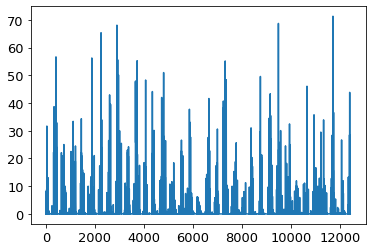

In [56]:
plt.plot(tmp2m_samp)

In [57]:
y_samp = tmp2m_samp.copy()

In [58]:
tmp2m_samp.shape, mjo_samp.shape

((12418, 1), (12418, 1))

In [59]:
y_total = y_samp.copy()
# concatenate tmp and MJO
# X_total = np.concatenate((mjo_samp, tmp2m_samp),axis=1)
X_total = mjo_samp.copy()

# Calculate moving average
avg_window = 14
y_movavg = []
X_movavg = []
for i in range(y_total.shape[0]-avg_window):
    y_avg = np.mean(y_total[i:i+avg_window])
    y_movavg.append(y_avg)
    X_avg = np.mean(X_total[i:i+avg_window],axis=0)
    X_movavg.append(X_avg)
y_movavg = np.array(y_movavg)
X_movavg = np.array(X_movavg)
y_total = y_movavg
X_total = X_movavg

train_size = int(y_total.shape[0]*0.8)
test_size = y_total.shape[0] - train_size

y_train = y_total[0:train_size]
y_test = y_total[train_size:]
X_train = X_total[0:train_size]
X_test = X_total[train_size:]

In [60]:
X_mins = np.amin(X_train,axis=0)
# y_min = np.amin(y_train,axis=0)
X_train = X_train - X_mins
X_test = X_test - X_mins
# y_train = y_train - y_min
# y_test = y_test - y_min
X_maxs = np.amax(X_train,axis=0)
# y_max = np.amax(y_train,axis=0)
X_train = X_train/X_maxs
X_test = X_test/X_maxs
# y_train = y_train/y_max
# y_test = y_test/y_max

In [61]:
np.min(X_train), np.max(X_train), np.min(X_test), np.max(X_test)

(0.0, 1.0, 0.028217985231128426, 0.985588211878302)

In [62]:
np.min(y_train), np.max(y_train), np.min(y_test), np.max(y_test)


(0.0, 21.643154195376805, 0.0, 12.332775666511484)

In [63]:
y_train = np.log10(y_train + 1.0)
y_test = np.log10(y_test + 1.0) 

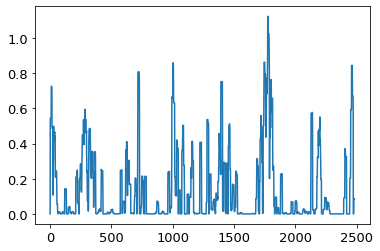

In [64]:
plt.plot(y_test)

In [65]:
train_precip = y_train.copy()
test_precip = y_test.copy()

In [66]:
train_precip[train_precip < 0.4] = 0.0
train_precip[train_precip >= 0.4] = 1.0

test_precip[test_precip < 0.4] = 0.0
test_precip[test_precip >= 0.4] = 1.0

In [67]:
y_train = train_precip.copy()
y_test = test_precip.copy()

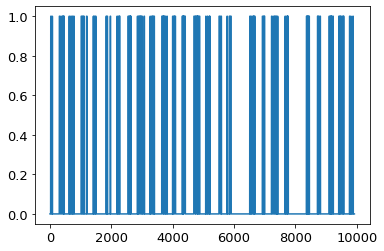

In [68]:
plt.plot(train_precip)

In [69]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [105]:
def create_sequence(input_data, y, train_window,pred_window):  #  Create sequences of observations for training
    seq = []
    L = len(input_data)
    feature_size = input_data[0].shape[0]
    for i in range(L-train_window-pred_window):
        train_seq = input_data[i:i+train_window]
        train_label = y[i+train_window+pred_window-1] # get y_t+14
        seq.append((train_seq ,train_label))
    return seq

In [106]:
y_train = np.reshape(y_train,(-1,1))  #  Matching dimension for concatenating X and y
y_test = np.reshape(y_test,(-1,1)) 

# train_data_array = np.concatenate((X_train,y_train),axis=1)
train_data_array = X_train.copy()
# train_data_array[:, 1] = train_precip.copy()
train_data = torch.FloatTensor(train_data_array)
y_train = torch.FloatTensor(y_train)

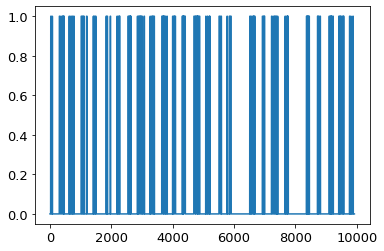

In [107]:
plt.plot(y_train)

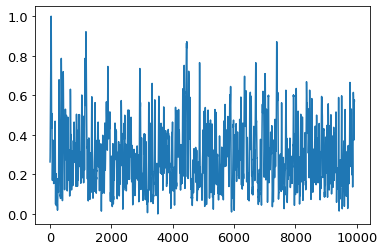

In [108]:
plt.plot(train_data_array)

In [109]:
train_data_array.shape

(9923, 1)

In [110]:
# train_data_array

In [111]:
train_window = 90
pred_window = 28
train_seq = create_sequence(train_data,y_train, train_window, pred_window)

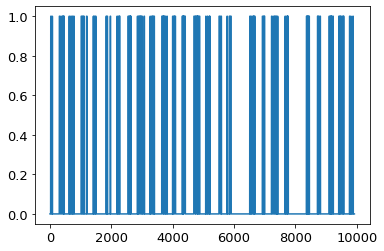

In [112]:
plt.plot(y_train)

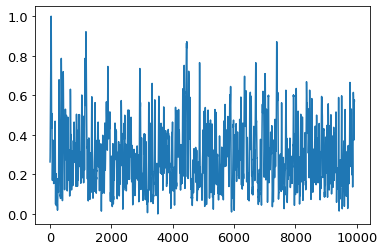

In [113]:
plt.plot(X_train)

In [114]:
class SeqDataset(Dataset):
    def __init__(self, seq_data, transform=None):
        
        self.seq_data = seq_data
        self.x = []
        self.y = []
        for i in range(len(self.seq_data)):
            self.x.append(self.seq_data[i][0])
            self.y.append(self.seq_data[i][1])

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        return (self.x[idx], self.y[idx])

    def __len__(self):
        return len(train_seq) #self._x.shape[0]

In [115]:
dataset_train = SeqDataset(train_seq)
dataloader_train = DataLoader(dataset_train,
                              batch_size=128,
                              shuffle=False,
                              num_workers=0,
                              pin_memory=False
                             )

In [116]:
d_input = 1 # From dataset
d_output = 1 # From dataset

attention_size = 8
LR = 1e-5 #1e-3
d_model = 64
q = 8 # Query size
v = 8 # Value size
h = 8 # Number of heads
N = 4 # Number of encoder and decoder to stack
dropout = 0.2 # Dropout rate
# pe = 'original' # Positional encoding
chunk_mode = None
net = Transformer(d_input, d_model, d_output, q, v, h, N, attention_size=attention_size, 
                  dropout=dropout, chunk_mode=chunk_mode, pe='regular', pe_period=2, seq_length=90).to(device)
# net = nn.Sequential(Transformer(d_input, d_model, d_output, q, v, h, N, attention_size=attention_size, 
#                   dropout=dropout, chunk_mode=chunk_mode, pe=pe),
#                     nn.Flatten(),
#                     nn.Linear(30, 1),
#                    ).to(device)
optimizer = optim.Adam(net.parameters(), lr=LR)
loss_function = nn.BCELoss() #OZELoss(alpha=0.3)

In [117]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(net)

2316572

In [118]:
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score

In [119]:
y_label[:10]

tensor([[0.1649],
        [0.1580],
        [0.1536],
        [0.1575],
        [0.1663],
        [0.1733],
        [0.1782],
        [0.1815],
        [0.1911],
        [0.2006]])

[Epoch   1/90]:   0%|          | 0/9805 [00:00<?, ?it/s]/home-nfs/tenzorok/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass labels=binary as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
[Epoch  76/90]: 100%|██████████| 9805/9805 [00:13<00:00, 745.45it/s, loss=0.461, acc=0.821, f1=0.338]


[Epoch  90/90]: 100%|██████████| 9805/9805 [00:13<00:00, 741.67it/s, loss=0.46, acc=0.821, f1=0.327]


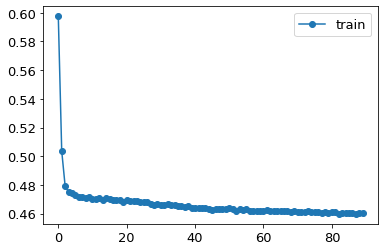

In [120]:
EPOCHS = 90
hist_loss = np.zeros(EPOCHS)
hist_loss_val = np.zeros(EPOCHS)

for idx_epoch in range(EPOCHS):
    running_loss = 0
    running_acc = 0
    running_f1 = 0
    with tqdm(total=len(train_seq), desc=f"[Epoch {idx_epoch+1:3d}/{EPOCHS}]") as pbar:
        for idx_batch, (x, y_label) in enumerate(dataloader_train):
#             x = x.unsqueeze(0)
            y_label = y_label.view(-1,1)
            optimizer.zero_grad()

            # Propagate input
            netout = net(x.to(device))

            # Compute loss
            loss = loss_function(netout, y_label.to(device)) 
            #myLoss(y_label.to(device), netout)#loss_function(y_label.to(device), netout) 

            # Backpropage loss
            loss.backward()

            # Update weights
            optimizer.step()
            
            acc = (netout.cpu().round() == y_label).sum() / len(netout) 
            f1 = f1_score(y_label.numpy(), netout.cpu().round().detach().numpy(), 'binary', zero_division=1)
#             acc = (torch.sigmoid(netout.cpu()).round() == y_label).sum() / len(netout)
#             f1 = f1_score(y_label.numpy(), torch.sigmoid(netout).cpu().round().detach().numpy(), 'binary', zero_division=1)
            running_loss += loss.item()
            running_acc += acc.item()
            running_f1 += f1
            pbar.set_postfix({'loss': running_loss/(idx_batch+1), 'acc': acc.item(), 'f1': f1})
            pbar.update(x.shape[0])
                
#         scheduler.step()    
        train_loss = running_loss/len(dataloader_train) 
        train_acc = running_acc/len(dataloader_train)
        train_f1 = running_f1/len(dataloader_train)
#         print('pred, target', netout, y)
#         val_loss = compute_loss(net, dataloader_val, loss_function, device).item()
#         pbar.set_postfix({'loss': train_loss, 'val_loss': val_loss})
#         if idx_epoch == EPOCHS-1:
        pbar.set_postfix({'loss': train_loss, 'acc': train_acc, 'f1': train_f1})
            

        hist_loss[idx_epoch] = train_loss
#         hist_loss_val[idx_epoch] = val_loss

#         if val_loss < val_loss_best:
#             val_loss_best = val_loss
#             torch.save(net.state_dict(), model_save_path)
        
plt.plot(hist_loss, 'o-', label='train')
# plt.plot(hist_loss_val, 'o-', label='val')
plt.legend()
# print(f"model exported to {model_save_path} with loss {val_loss_best:5f}")

In [122]:
train_test_total = np.concatenate((train_data_array, X_test))

net.eval()
num_pred = 1 #  Number of prediction forward, i.e. tau
res = np.zeros(train_window).tolist()
#  Predicting y using X_test and y_test
for i in tqdm(range(train_test_total.shape[0]-train_window)):
    for j in range(num_pred):
        seq = torch.FloatTensor(train_test_total[i:i+train_window]).to(device)
        seq = seq.unsqueeze(0)
        #print(seq)
        with torch.no_grad():
            #print(model(seq))
            pred = net(seq).cpu()
            #print(len(test_inputs))
            res.append(pred.round())
            
res = np.array(res)

100%|██████████| 12314/12314 [04:55<00:00, 41.61it/s]


In [126]:
y_all = np.concatenate((y_train.cpu(), y_test))

In [124]:
res.shape, res[train_window:-test_size-pred_window].shape,  res[-test_size-pred_window:-pred_window].shape

((12404,), (9805,), (2481,))

r-sq on train: -0.21770897832817315
r-sq on test: -0.157722818478768
cosine_similarity on train: [[0.]]
cosine_similarity on test: [[0.]]
f1 train: 0.0
f1 test: 0.0
acc train: 0.821214278450117
acc test: 0.8637646110439339
roc-auc train: 0.5
roc-auc test: 0.5


/home-nfs/tenzorok/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass labels=binary as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


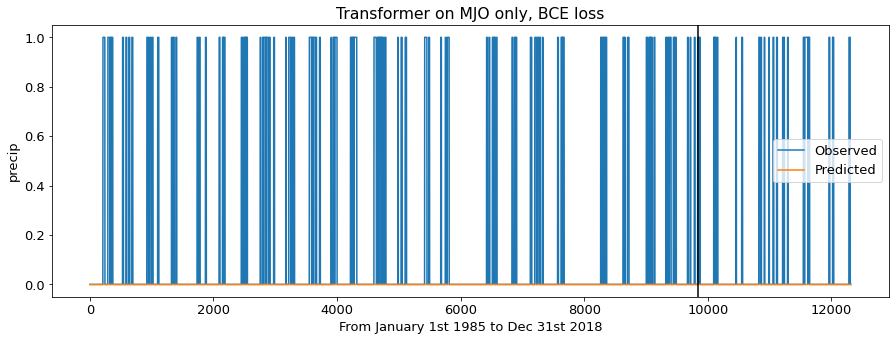

In [127]:
print('r-sq on train:', r2_score(y_all[train_window:-test_size], res[train_window:-test_size]))
print('r-sq on test:', r2_score(y_all[-test_size:],  res[-test_size:]))
print('cosine_similarity on train:', cosine_similarity(y_all[train_window:-test_size].reshape((1,-1)), res[train_window:-test_size].reshape((1,-1))))
print('cosine_similarity on test:', cosine_similarity(y_all[-test_size:].reshape((1,-1)),  res[-test_size:].reshape((1,-1))))
print('f1 train:', f1_score(y_all[train_window:-test_size], res[train_window:-test_size], 'binary', zero_division=1))
print('f1 test:', f1_score(y_all[-test_size:],  res[-test_size:] , 'binary', zero_division=1))
print('acc train:', accuracy_score(y_all[train_window:-test_size], res[train_window:-test_size]))
print('acc test:', accuracy_score(y_all[-test_size:],  res[-test_size:]))
print('roc-auc train:', roc_auc_score(y_all[train_window:-test_size], res[train_window:-test_size]))
print('roc-auc test:', roc_auc_score(y_all[-test_size:],  res[-test_size:]))

plt.figure(figsize=(15,5))
plt.plot(y_all[train_window:],label='Observed')
plt.plot(res[train_window:],label='Predicted')
plt.legend()
plt.xlabel('From January 1st 1985 to Dec 31st 2018')
plt.ylabel(target)
plt.title('Transformer on MJO only, BCE loss')
plt.axvline(x=res.shape[0] - test_size-train_window,c='black');

In [141]:
# torch.save(net.state_dict(), 'model_mjo.pth')

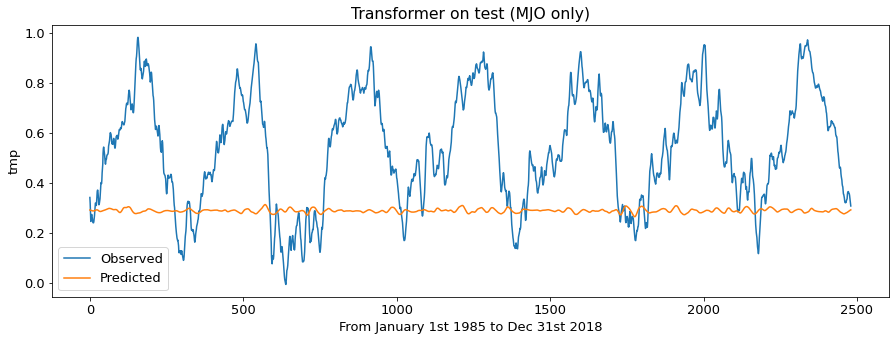

In [39]:
plt.figure(figsize=(15,5))
plt.plot(y_test,label='Observed')
plt.plot(res[-test_size-pred_window:-pred_window],label='Predicted')
plt.legend()
plt.xlabel('From January 1st 1985 to Dec 31st 2018')
plt.ylabel(target)
plt.title('Transformer on test (MJO only)');

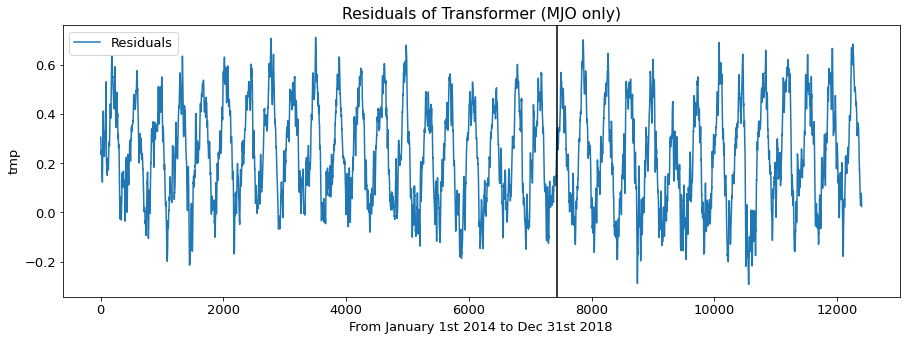

In [41]:
plt.figure(figsize=(15,5))
plt.plot(np.squeeze(y_all) - res ,label='Residuals')
plt.legend()
plt.xlabel('From January 1st 2014 to Dec 31st 2018')
plt.ylabel(target)
plt.title('Residuals of Transformer (MJO only)');
plt.axvline(x=X_train.shape[0]- test_size,c='black');

In [128]:
def create_sequence_with_reshape(input_data, y, train_window, pred_window):  #  Create sequences of observations for training
    seq_x = []
    seq_y = []
    L = len(input_data)
    feature_size = input_data[0].shape[0]
    print('feature_size', feature_size)
    for i in range(L - train_window-pred_window):
        train_seq = input_data[i:i+train_window].ravel()
        train_label = y[i+train_window+pred_window-1] # get y_t+14
#         train_label = input_data[i + train_window + pred_window]
        seq_x.append(train_seq)
        seq_y.append(train_label)
        
#     print('train_seq, train_label', seq_x.shape, seq_y.shape)
    return seq_x, seq_y

In [129]:
train_window = 90
pred_window = 28
train_seq_x, train_seq_y = create_sequence_with_reshape(train_data_array, y_train, train_window, pred_window)

feature_size 1


In [130]:
test_data_array = X_test.copy()

In [131]:
test_seq_x, test_seq_y = create_sequence_with_reshape(np.concatenate((train_data_array[-90-28:], test_data_array), 
                                                                     axis=0), 
                                                      np.concatenate((test_data_array[-90-28:], y_test), axis=0),
                                                      train_window, pred_window)

feature_size 1


In [132]:
np.concatenate((train_data_array[-90-28:], test_data_array), axis=0).shape

(2599, 1)

In [133]:
np.concatenate((test_data_array[-90-28:], y_test)).shape

(2599, 1)

In [134]:
class XGBoost():
    def __init__(self, num_models=3274, base_score=0.5, booster='gbtree', colsample_bylevel=1,
                 colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
                 min_child_weight=1, missing=None, n_estimators=100,
                 n_jobs=16, nthread=None, objective='reg:squarederror',
                 random_state=0, reg_alpha=0, reg_lambda=1,
                 scale_pos_weight=1, seed=None, silent=True, subsample=1):


        """ Initilize a list of XGBoost 
        """
        super().__init__()    

        self.models = [xgb.XGBRegressor(objective=objective, max_depth=max_depth, learning_rate=learning_rate,
                                        colsample_bytree=colsample_bytree, n_estimators=n_estimators, gamma=gamma,
                                        base_score=base_score, booster=booster, colsample_bylevel=colsample_bylevel,
                                        max_delta_step=max_delta_step, min_child_weight=min_child_weight, missing=missing,
                                        n_jobs=1, nthread=nthread, random_state=random_state,
                                        reg_alpha=reg_alpha, reg_lambda=reg_lambda,
                                        scale_pos_weight=scale_pos_weight, seed=seed,
                                        silent=silent, subsample=subsample, tree_method='gpu_hist', n_gpus=1) for i in range(num_models)]
        self.n_jobs = n_jobs
        self.num_models = num_models



    def fit(self, X, y):

        """ fit XGBoost model at each location
        """
#         self.models = Parallel(n_jobs=self.n_jobs)(delayed(self.models[loc].fit)(X, y[:, loc]) for loc in range(self.num_models))# 197x2x num_estimators
        self.models = Parallel(n_jobs=self.n_jobs)(delayed(self.models[loc].fit)(X, y) for loc in range(self.num_models))

        return self.models
  

    def fit_cv(self, train_x, train_y, val_x, val_y):

        """ For hyper-parameter tuning: fit XGBoost model at each location
        """
        history = np.asarray(Parallel(n_jobs=self.n_jobs)(delayed(self.fit_single_output)
                                                          (self.models[loc], train_x, train_y[:, loc], val_x, val_y[:, loc])
                                                          for loc in range(self.num_models)))# 197x2x num_estimators

        return history


    def predict(self, X):
        """ For XGBoost model at each location, make prediction
        """
        pred_y = np.asarray((Parallel(n_jobs=self.n_jobs)(delayed(self.models[loc].predict)(X) for loc in range(self.num_models))))# 197x2x num_estimators


        return pred_y.T


    def fit_single_output(self, mdl, train_x, train_y, test_x, test_y):
        """ For hyper-parameter tuning: fit XGBoost model at each location
        """
        eval_set = [(train_x, train_y), (test_x, test_y)]
        eval_metric = ['rmse']

        mdl.fit(train_x, train_y, eval_metric=eval_metric, eval_set=eval_set, verbose=True)


        train_eval = mdl.evals_result()['validation_0']['rmse']
        test_eval = mdl.evals_result()['validation_1']['rmse']


        return train_eval, test_eval

In [140]:
mdl = XGBoost(num_models=1, n_jobs=1, objective='binary:logistic')

In [141]:
train_seq_x = np.array(train_seq_x)
train_seq_y = np.array(train_seq_y)

test_seq_x = np.array(test_seq_x)
test_seq_y = np.array(test_seq_y).squeeze()

In [142]:
train_seq_x.shape, train_seq_y.shape

((9805, 90), (9805,))

In [143]:
test_seq_x.shape, test_seq_y.shape

((2481, 90), (2481,))

In [144]:
mdl.fit(train_seq_x, train_seq_y)

[07:49:27] WARNING: ../include/xgboost/generic_parameters.h:39: 
n_gpus: 
	Deprecated. Single process multi-GPU training is no longer supported.
	Please switch to distributed training with one process per GPU.
	This can be done using Dask or Spark.  See documentation for details.
[07:49:27] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[07:49:28] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:49:28] WARNING: ../include/xgboost/generic_parameters.h:39: 
n_gpus: 
	Deprecated. Single process multi-GPU training is no longer support

[XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, monotone_constraints='()',
              n_estimators=100, n_gpus=1, n_jobs=1, nthread=1,
              num_parallel_tree=1, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0, silent=True,
              subsample=1, tree_method='gpu_hist', validate_parameters=1, ...)]

In [145]:
pred_train = mdl.predict(np.array(train_seq_x))
pred_test = mdl.predict(np.array(test_seq_x))

f1 train: 0.17610710607621008
f1 test: 0.026385224274406333
acc train: 0.8368179500254972
acc test: 0.8512696493349455
roc-auc train: 0.8217341011206489
roc-auc test: 0.5561867867585948


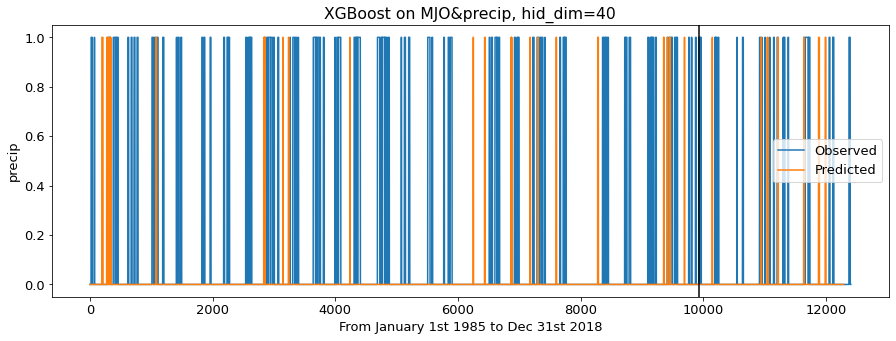

In [146]:
print('f1 train:', f1_score(y_train[90+28:], pred_train.round()))
print('f1 test:', f1_score(y_test,  pred_test.round()))
print('acc train:', accuracy_score(y_train[90+28:], pred_train.round()))
print('acc test:', accuracy_score(y_test,  pred_test.round()))
print('roc-auc train:', roc_auc_score(y_train[90+28:], pred_train))
print('roc-auc test:', roc_auc_score(y_test,  pred_test))

plt.figure(figsize=(15,5))
plt.plot(np.concatenate((y_train, y_test)),label='Observed')
plt.plot(np.concatenate((pred_train.round(), pred_test.round())),label='Predicted')
plt.legend()
plt.xlabel('From January 1st 1985 to Dec 31st 2018')
plt.ylabel(target)
plt.title('XGBoost on MJO&precip, hid_dim=40')
plt.axvline(x=len(y_train),c='black');

r-sq on train: 0.2504329893634534
r-sq on test: 0.0024536975963654895
cosine_similarity on train: [[0.9506593]]
cosine_similarity on test: [[0.92464236]]


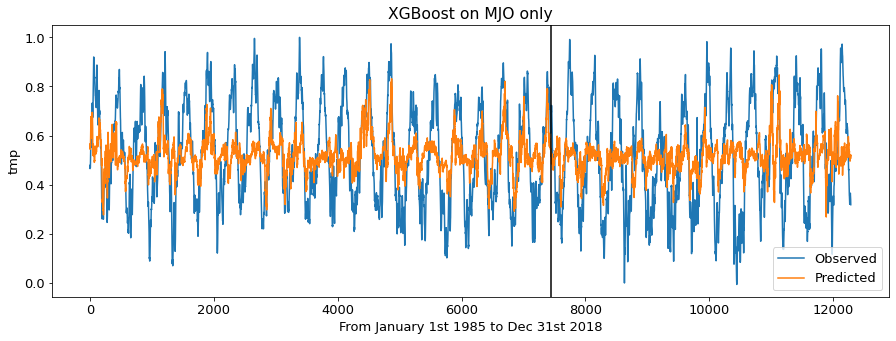

In [157]:
print('r-sq on train:', r2_score(train_seq_y, pred_train))
print('r-sq on test:', r2_score(test_seq_y[train_window+pred_window:],  pred_test[train_window+pred_window:]))
print('cosine_similarity on train:', cosine_similarity(train_seq_y.reshape((1,-1)), pred_train.reshape((1,-1))))
print('cosine_similarity on test:', cosine_similarity(test_seq_y.reshape((1,-1)),  pred_test.reshape((1,-1))))
plt.figure(figsize=(15,5))
plt.plot(np.concatenate((train_seq_y, test_seq_y)),label='Observed')
plt.plot(np.concatenate((pred_train, pred_test)),label='Predicted')
plt.legend()
plt.xlabel('From January 1st 1985 to Dec 31st 2018')
plt.ylabel(target)
plt.title('XGBoost on MJO only')
plt.axvline(x=X_train.shape[0]- test_size,c='black');

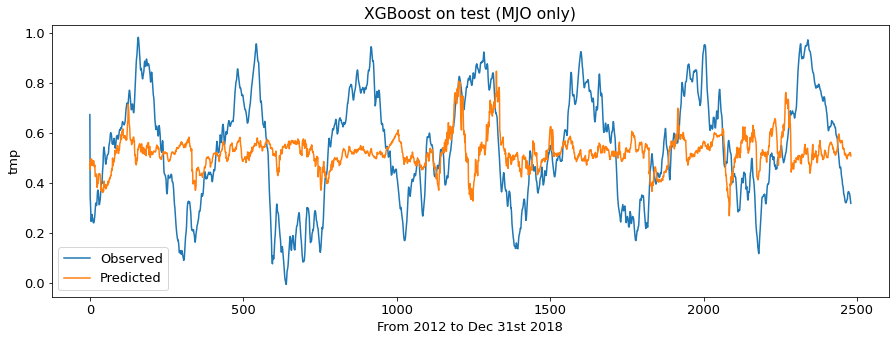

In [158]:
plt.figure(figsize=(15,5))
plt.plot(test_seq_y,label='Observed')
plt.plot(pred_test, label='Predicted')
plt.legend()
plt.xlabel('From 2012 to Dec 31st 2018')
plt.ylabel(target)
plt.title('XGBoost on test (MJO only)');

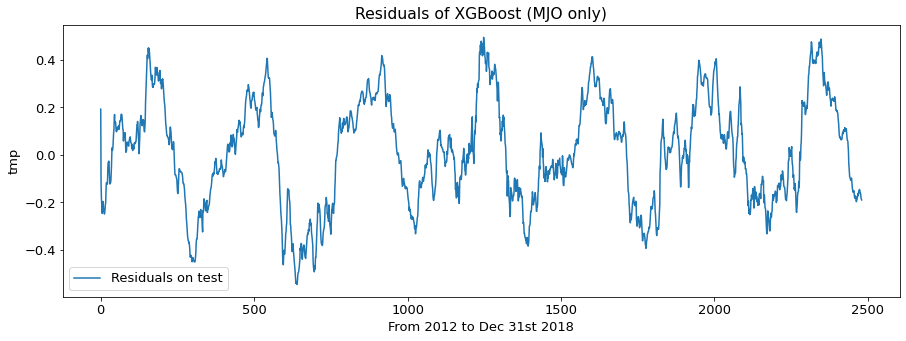

In [159]:
plt.figure(figsize=(15,5))
plt.plot(test_seq_y - pred_test.squeeze(),label='Residuals on test')
plt.legend()
plt.xlabel('From 2012 to Dec 31st 2018')
plt.ylabel('tmp')
plt.title('Residuals of XGBoost (MJO only)');